In [56]:
import numpy as np
import matplotlib.pyplot as plt

from experiment_framework.empirical_bootstrap import EmpiricalBootstrap, SampleGenerator
from experiment_framework.asymptotic_analysis import construct_bootstrap, transform_n_to_k_for_knn, asymptotic_curve
from notebook_context import *

m_hat = 0.6505070570864114


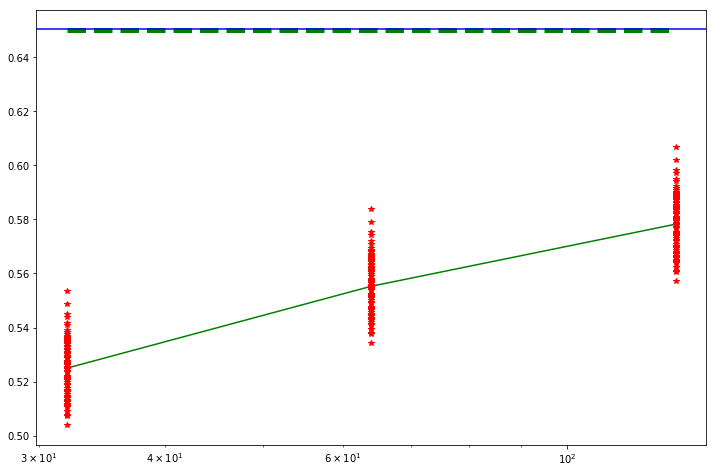

In [57]:
N = np.array([2**i for i in range(5,8)])
m = 0.65
c = 0.5
d = 3
e = 2/(d+2)

def model(n):
    return m - c*1/(n**e)

def noise(n):
    return 0.01 * np.random.randn()

def noisy_model(n):
    return model(n) + noise(n)

plt.figure(figsize=(12,8))

plt.semilogx(N, model(N), '-*g')
plt.semilogx(N, np.ones_like(N)*m, '--g', linewidth=5)


def gen_data(n_trials=100):
    X = N
    y = noisy_model(N)
    for _ in range(n_trials-1):
        X = np.vstack((X, N))
        y = np.vstack((y, noisy_model(N)))
    X = X.astype(np.double)  # for transformation to Ks

    return X, y

X, y = gen_data(100)
_ = plt.semilogx(X, y, '*r')

Ks = transform_n_to_k_for_knn(X, 'gyorfi', d=3)
m_hat, C_hat = asymptotic_curve(Ks.reshape(Ks.size), y.reshape(y.size))
plt.axhline(m_hat, color='b')
print('m_hat = {}'.format(m_hat))

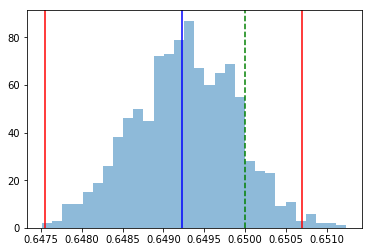

In [35]:
X, y = gen_data(300)
# X = X.reshape(X.size)
# y = y.reshape(y.size)
EB = construct_bootstrap(X=X, d=3, fit_model='gyorfi', classifier_accuracies=y)
sampled_asymptotes = EB.bootstrap_confidence_bounds(0.99, n_samples=1000)
_ = plt.hist(EB.generated_samples, alpha=0.5, bins=30)
plt.axvline(sampled_asymptotes.lb_two_sided, color='r')
plt.axvline(sampled_asymptotes.ub_two_sided, color='r')
plt.axvline(m, color='g', linestyle='--')
plt.axvline(EB.sample_generator.sample_mean, color='b')

In [58]:
results = []
from multiprocessing import Pool

In [63]:
def try_bootstrap(*args):
    np.random.seed()
    X, y = gen_data(300)
    EB = construct_bootstrap(X=X, d=3, fit_model='gyorfi', classifier_accuracies=y)
    sampled_asymptotes = EB.bootstrap_confidence_bounds(0.99, n_samples=1000)
    if sampled_asymptotes.lb_two_sided <= m <= sampled_asymptotes.ub_two_sided:
        return 1
    else:
        return 0


with Pool() as pool:
    results.extend(pool.map(try_bootstrap, range(10000)))
n_success = sum(results)
n_trials = len(results)
print(n_success/n_trials)

0.9895


In [64]:
print(n_trials)

30000
